### Import

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/CHALL2

Mounted at /gdrive
/gdrive/My Drive/CHALL2


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

# splitting data w/ stratify
from sklearn.model_selection import train_test_split

### Load data


In [ ]:
categories = np.load ("./categories.npy", allow_pickle = True)
training_data = np.load ("./training_data.npy", allow_pickle = True)
valid_periods = np.load ("./valid_periods.npy", allow_pickle = True)

In [ ]:
categories.shape, training_data.shape, valid_periods.shape

categories.dtype, training_data.dtype, valid_periods.dtype

(dtype('<U1'), dtype('float64'), dtype('int64'))

In [ ]:
# Define categories
unique_categories = np.unique(categories)
print(unique_categories)

['A' 'B' 'C' 'D' 'E' 'F']


### Data prep + splitting

REMOVING DUPLICATES

In [ ]:
def remove_duplicates(training_data, categories, valid_periods):

  unique_sequences, counts = np.unique(training_data, return_counts=True, axis=0)
  print("Unique sequences:", len(unique_sequences))

  # Get the indices of all the unique sequences in the dataset
  _, indexes = np.unique(training_data, return_index=True, axis=0)

  # Get the categories of each unique sequence in the dataset
  unique_categories = categories[indexes]

  # Get the valid periods of each unique sequence in the dataset
  unique_valid_periods = valid_periods[indexes]

  # print duplicates' infos
  dup_sequences = unique_sequences[counts > 1]
  print(len(training_data)-len(unique_sequences), "duplicates deleted from", len(training_data), "sequences in the dataset")

  return unique_sequences, unique_categories,  unique_valid_periods

In [ ]:
training_data, categories, valid_periods = remove_duplicates(training_data,categories, valid_periods)

Unique sequences: 47974
26 duplicates deleted from 48000 sequences in the dataset


In [ ]:
print(training_data.shape, categories.shape, valid_periods.shape)

(47974, 2776) (47974,) (47974, 2)


In [ ]:
new_training_data = np.pad(training_data, ((0, 0), (24, 0)), 'constant')


print(new_training_data[0])

[0.         0.         0.         ... 0.74328417 0.62639178 0.7536182 ]


SPLITTIG DATA MANTAINING PROPRORTION FOR CATEGORY

In [ ]:
def split_train_val(training_data, categories, split_size=0.1, seed=seed):

  df = pd.DataFrame(training_data)
  df['category'] = categories

  # Proportionate Sampling
  df_train, df_val = train_test_split(df, test_size=0.1, random_state=seed, stratify=df[['category']], shuffle=True)

   # Split sequences array
  df_train = df_train.drop(columns=['category'])
  df_val = df_val.drop(columns=['category'])
  train_data = df_train.to_numpy()
  val_data = df_val.to_numpy()

  return  train_data, val_data

In [ ]:
X_train_raw , X_val_raw = split_train_val(new_training_data,categories, 0.1, 42)

print (X_train_raw.shape, X_val_raw.shape)


(43176, 2800) (4798, 2800)


PLOTTING SOME GRAPH FOR VISUALIZING  

In [ ]:
to_predict = 18
X_train_raw_to_plot = training_data[:, :-to_predict]
X_train_raw_to_predict = training_data[:, -to_predict:]
print(X_train_raw_to_plot.shape, X_train_raw_to_predict.shape)

(47974, 2758) (47974, 18)


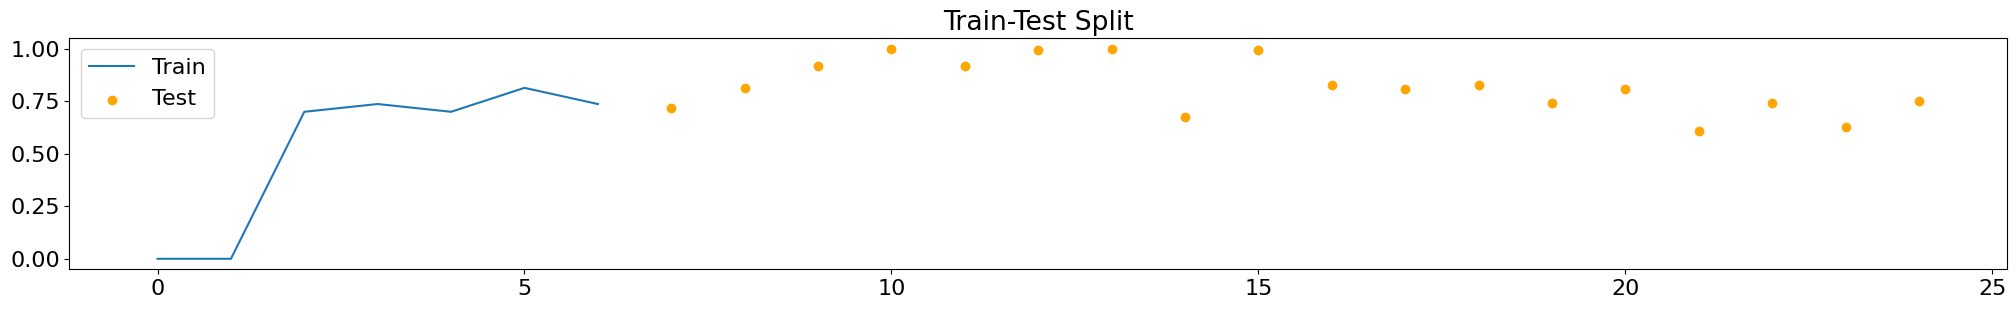

In [ ]:
plt.figure(figsize=(25,3))
start,stop = valid_periods[0]
plt.plot(X_train_raw_to_plot[0][start:], label='Train')
plt.scatter(np.arange(stop-start-18,stop-start),X_train_raw_to_predict[0], label='Test',color="orange")
plt.title('Train-Test Split')
plt.legend()
plt.show()

BUILDING SEQUENCES

In [ ]:
def build_sequences(training_data, window, telescope,stride):

  seq_train=[]
  seq_predict=[]

  for i in range(len(training_data)):


    for idx in np.arange((len(training_data[i])-window-telescope), 0,-stride):

      if(np.logical_and(training_data[i][idx] == 0 , training_data[i][idx+window] == 0)):
        break

      seq_train.append(training_data[i][idx:idx+window])
      seq_predict.append(training_data[i][idx+window:idx+window+telescope])

  return np.array(seq_train), np.array(seq_predict)

In [ ]:
#window = 200
window = 50
telescope = 18
stride = 10

In [ ]:
X_train, y_train = build_sequences(X_train_raw, window, telescope,stride)
X_val, y_val = build_sequences(X_val_raw, window, telescope,stride)

print (X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(798877, 50) (798877, 18) (88859, 50) (88859, 18)


### Function helper

In [ ]:
# Plot model's history graph
def plot_history(history):

  best_epoch = np.argmin(history['val_loss'])
  plt.figure(figsize=(17,4))
  plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
  plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.title('Mean Squared Error')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

  plt.figure(figsize=(18,3))
  plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

In [ ]:
# Print model's MSE + MAE
def prediction_performance(X_test, y_test, model):
  # Predict the test set using the model
  predictions = model.predict(X_test, verbose=0)

  # Print the shape of the predictions
  print(f"Predictions shape: {predictions.shape}")

  # Calculate and print Mean Squared Error (MSE)
  mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
  print(f"Mean Squared Error: {mean_squared_error}")

  # Calculate and print Mean Absolute Error (MAE)
  mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
  print(f"Mean Absolute Error: {mean_absolute_error}")

  return mean_squared_error, mean_absolute_error


In [ ]:
ranking = {}

### Build basic model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200


print(input_shape)
print(output_shape)

## su codalab input shape = (60,200) output shape = (60,9) !!

(200,)
(9,)


In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    #Reshape bcz "bidirectional_lstm" expected ndim=3
    x = tfkl.Reshape((input_shape[0], 1), input_shape = input_shape)(input_layer)


    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(1, 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    #Reshape bcz i want an output of just 9 value
    output_layer = tfkl.Reshape(output_shape, input_shape = (output_shape[0], 1))(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 200, 1)            0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)              0         
                                                   

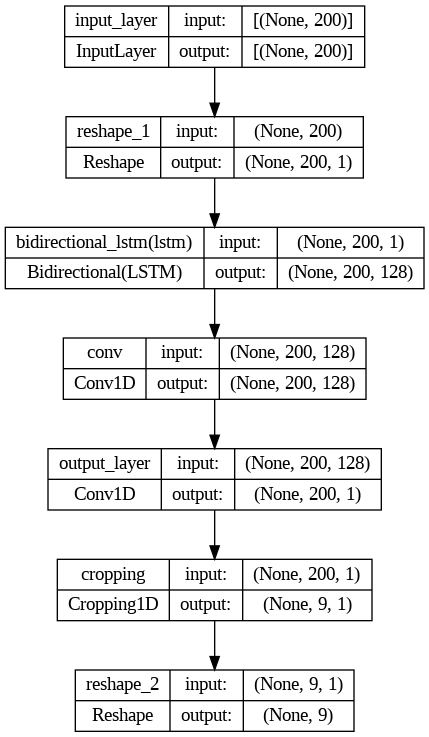

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
1437/1437 [==============================] - 33s 18ms/step - loss: 0.0711 - val_loss: 0.0728 - lr: 0.0010
Epoch 2/200
1437/1437 [==============================] - 26s 18ms/step - loss: 0.0668 - val_loss: 0.0760 - lr: 0.0010
Epoch 3/200
1437/1437 [==============================] - 26s 18ms/step - loss: 0.0710 - val_loss: 0.0700 - lr: 0.0010
Epoch 4/200
1437/1437 [==============================] - 25s 17ms/step - loss: 0.0710 - val_loss: 0.0700 - lr: 0.0010
Epoch 5/200
1437/1437 [==============================] - 25s 17ms/step - loss: 0.0706 - val_loss: 0.0698 - lr: 0.0010
Epoch 6/200
1437/1437 [==============================] - 26s 18ms/step - loss: 0.0687 - val_loss: 0.0700 - lr: 0.0010
Epoch 7/200
1437/1437 [==============================] - 27s 19ms/step - loss: 0.0705 - val_loss: 0.0692 - lr: 0.0010
Epoch 8/200
1437/1437 [==============================] - 25s 17ms/step - loss: 0.0412 - val_loss: 0.0166 - lr: 0.0010
Epoch 9/200
1437/1437 [==============================] -

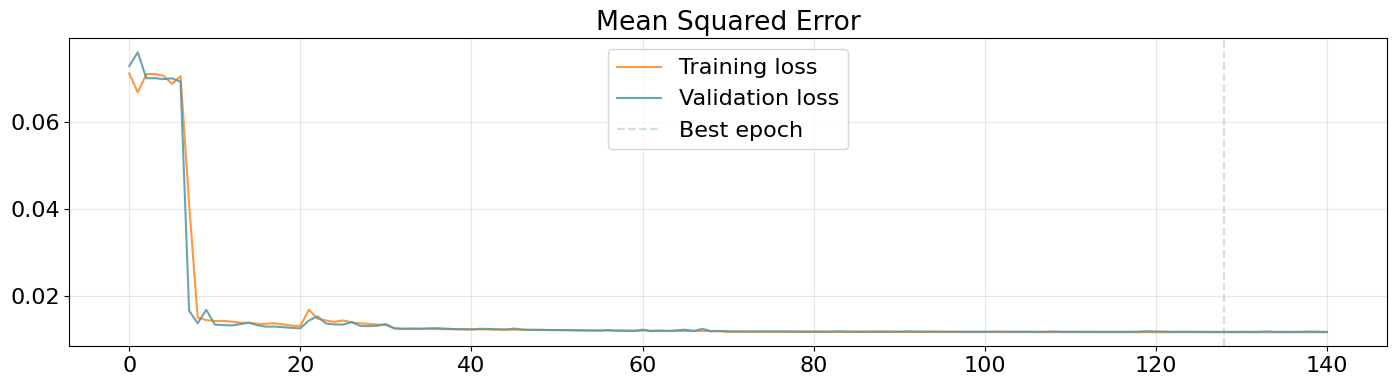

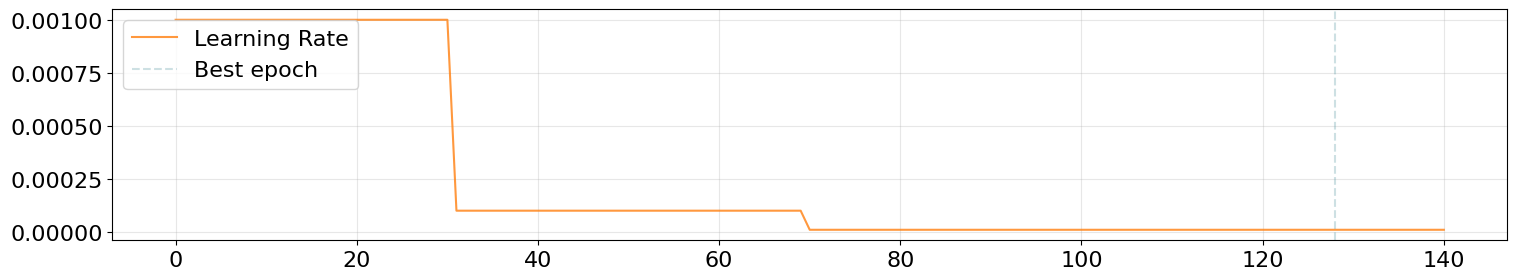

In [ ]:
plot_history(history)

In [ ]:
model.save('Forecasting_1')

In [ ]:
model = tfk.models.load_model('Forecasting_1')
mse, mae = prediction_performance(X_val,y_val,model)

ranking["Basic Model"] = mse,mae

Predictions shape: (11322, 9)
Mean Squared Error: 0.011557452380657196
Mean Absolute Error: 0.06997204571962357


### Build more complex model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

print(input_shape)
print(output_shape)

(200,)
(9,)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 reshape_3 (Reshape)         (None, 200, 1)            0         
                                                                 
 bidirectional (Bidirection  (None, 200, 300)          182400    
 al)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 200, 300)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 300)          541200    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 200, 300)          0     

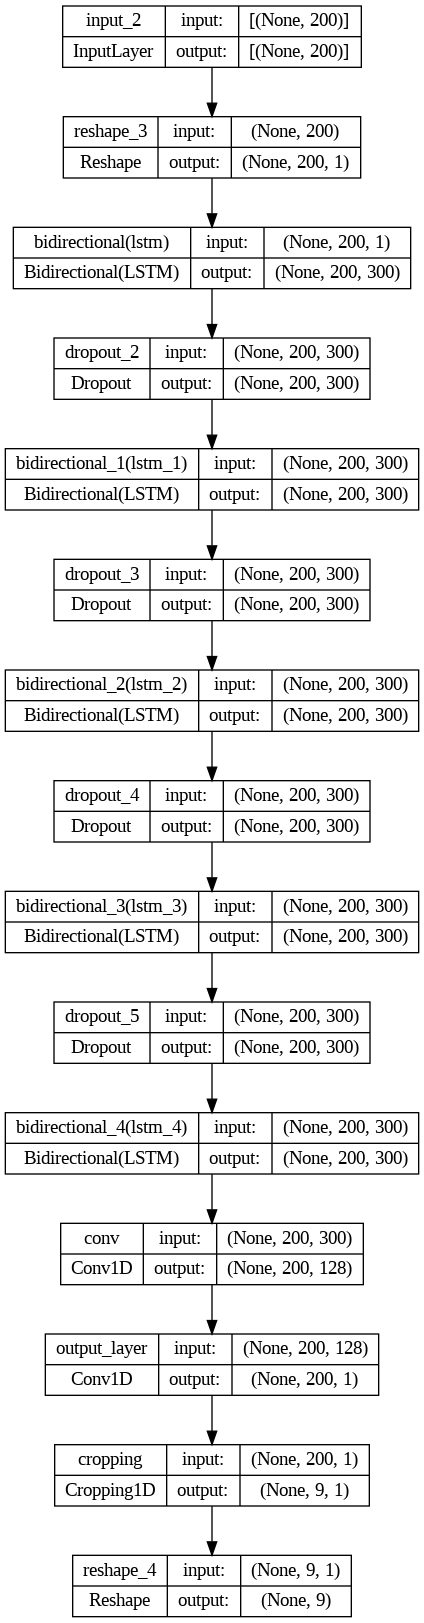

In [ ]:
# Create the model
input_layer = tfk.layers.Input(shape=input_shape)

x= tfkl.Reshape((input_shape[0], 1), input_shape = input_shape)(input_layer)

x = tfk.layers.Bidirectional(tfkl.LSTM(150, return_sequences= True))(x)
x = tfk.layers.Dropout(0.3)(x)
x = tfk.layers.Bidirectional(tfkl.LSTM(150, return_sequences=True))(x)
x = tfk.layers.Dropout(0.3)(x)
x = tfk.layers.Bidirectional(tfkl.LSTM(150, return_sequences= True))(x)
x = tfk.layers.Dropout(0.3)(x)
x = tfk.layers.Bidirectional(tfkl.LSTM(150, return_sequences=True))(x)
x = tfk.layers.Dropout(0.3)(x)
x = tfk.layers.Bidirectional(tfkl.LSTM(150, return_sequences=True))(x)

# Add a 1D Convolution layer with 128 filters and a kernel size of 3
x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

# Add a final Convolution layer to match the desired output shape
output_layer = tfkl.Conv1D(1, 3, padding='same', name='output_layer')(x)

# Calculate the size to crop from the output to match the output shape
crop_size = output_layer.shape[1] - output_shape[0]

# Crop the output to the desired length
output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

#Reshape bcz i want an output of just 9 value
output_layer = tfkl.Reshape(output_shape, input_shape = (output_shape[0], 1))(output_layer)



model = tfk.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss="mse")
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200


KeyboardInterrupt: ignored

In [ ]:
plot_history(history)

In [ ]:
model.save('Forecasting_1-complex')


In [ ]:
model = tfk.models.load_model('Forecasting_1-complex')
mse, mae = prediction_performance(X_val,y_val,model)

ranking["Complex Model"] = mse,mae

### GRU model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

print(input_shape)
print(output_shape)

(50,)
(18,)


In [ ]:
def build_gru(input_shape, output_shape, units):

    input_layer = tfkl.Input(shape = input_shape)
    x = tfkl.Reshape((input_shape[0], 1), input_shape = input_shape)(input_layer)
    x = tfkl.GRU (units = units, return_sequences = True)(x)
    x = tfkl.Dropout(0.2)(x)
    # Hidden layer
    x = tfkl.GRU(units = units)(x)
    x = tfkl.Dropout(0.2)(x)
    output_layer = tfkl.Dense(units = output_shape[0])(x)


    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='GRU_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 reshape_2 (Reshape)         (None, 50, 1)             0         
                                                                 
 gru_4 (GRU)                 (None, 50, 128)           50304     
                                                                 
 dropout_4 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 18)                23

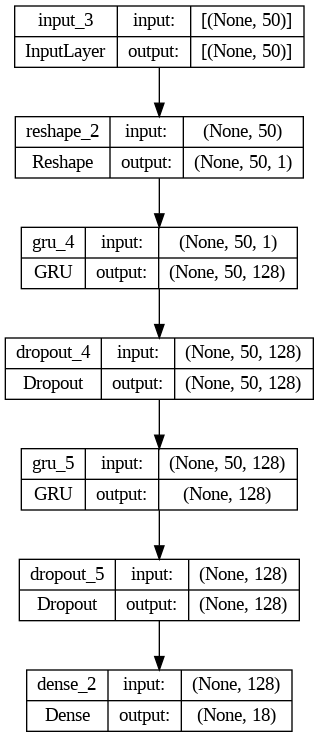

In [ ]:
model = build_gru(input_shape, output_shape,128)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
5618/5618 [==============================] - 64s 11ms/step - loss: 0.0179 - val_loss: 0.0152 - lr: 0.0010
Epoch 2/200
5618/5618 [==============================] - 48s 9ms/step - loss: 0.0148 - val_loss: 0.0143 - lr: 0.0010
Epoch 3/200
5618/5618 [==============================] - 48s 9ms/step - loss: 0.0142 - val_loss: 0.0139 - lr: 0.0010
Epoch 4/200
5618/5618 [==============================] - 49s 9ms/step - loss: 0.0139 - val_loss: 0.0137 - lr: 0.0010
Epoch 5/200
5618/5618 [==============================] - 48s 9ms/step - loss: 0.0138 - val_loss: 0.0135 - lr: 0.0010
Epoch 6/200
5618/5618 [==============================] - 51s 9ms/step - loss: 0.0136 - val_loss: 0.0133 - lr: 0.0010
Epoch 7/200
5618/5618 [==============================] - 48s 9ms/step - loss: 0.0134 - val_loss: 0.0132 - lr: 0.0010
Epoch 8/200
5618/5618 [==============================] - 48s 8ms/step - loss: 0.0133 - val_loss: 0.0132 - lr: 0.0010
Epoch 9/200
5618/5618 [==============================] - 48s 9m

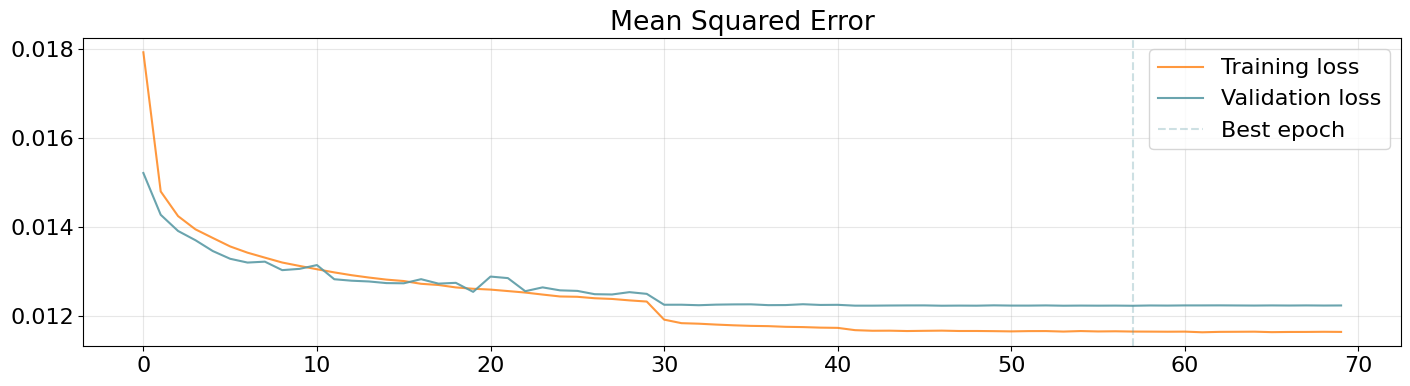

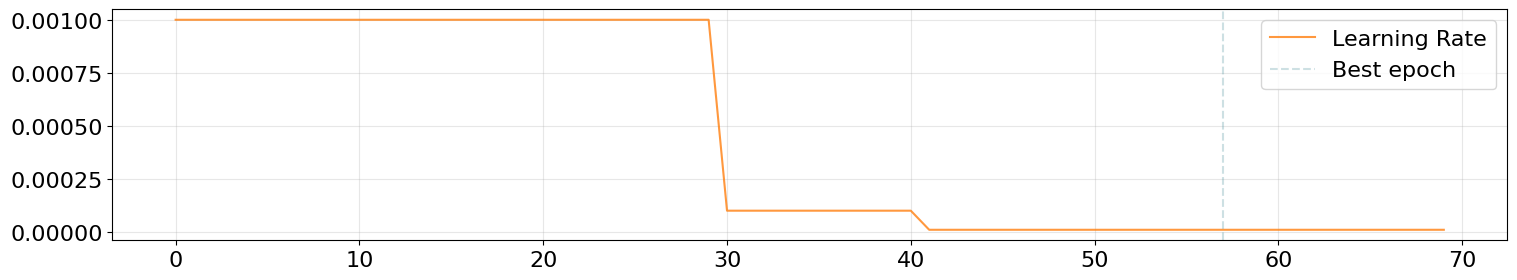

In [ ]:
plot_history(history)

In [ ]:
model.save('Forecasting_1-GRU-18')

In [ ]:
model = tfk.models.load_model('Forecasting_1-GRU-18')
mse, mae = prediction_performance(X_val,y_val,model)

ranking["GRU"] = mse, mae

Predictions shape: (88859, 18)
Mean Squared Error: 0.011727100238204002
Mean Absolute Error: 0.06976334750652313


### Bi-GRU model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

print(input_shape)
print(output_shape)

(50,)
(9,)


In [ ]:
def build_gru(input_shape, output_shape, units):

    input_layer = tfkl.Input(shape = input_shape)
    x = tfkl.Reshape((input_shape[0], 1), input_shape = input_shape)(input_layer)
    x = tfkl.Bidirectional(tfkl.GRU (units = units, return_sequences = True))(x)
    x = tfkl.Dropout(0.2)(x)
    # Hidden layer
    x = tfkl.Bidirectional(tfkl.GRU(units = units))(x)
    x = tfkl.Dropout(0.2)(x)
    output_layer = tfkl.Dense(units = output_shape[0])(x)


    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='Bi-GRU_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "Bi-GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 reshape (Reshape)           (None, 50, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           100608    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)              

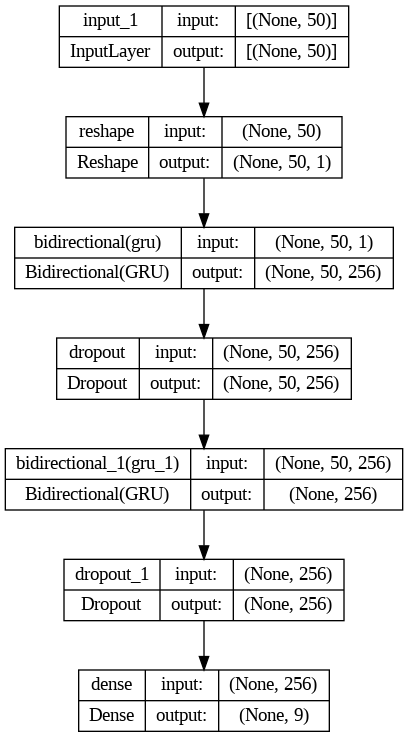

In [ ]:
model = build_gru(input_shape, output_shape,128)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
5857/5857 [==============================] - 106s 17ms/step - loss: 0.0127 - val_loss: 0.0107 - lr: 0.0010
Epoch 2/200
5857/5857 [==============================] - 98s 17ms/step - loss: 0.0106 - val_loss: 0.0100 - lr: 0.0010
Epoch 3/200
5857/5857 [==============================] - 98s 17ms/step - loss: 0.0101 - val_loss: 0.0097 - lr: 0.0010
Epoch 4/200
5857/5857 [==============================] - 99s 17ms/step - loss: 0.0098 - val_loss: 0.0095 - lr: 0.0010
Epoch 5/200
5857/5857 [==============================] - 98s 17ms/step - loss: 0.0096 - val_loss: 0.0094 - lr: 0.0010
Epoch 6/200
5857/5857 [==============================] - 99s 17ms/step - loss: 0.0095 - val_loss: 0.0093 - lr: 0.0010
Epoch 7/200
5857/5857 [==============================] - 97s 17ms/step - loss: 0.0094 - val_loss: 0.0092 - lr: 0.0010
Epoch 8/200
5857/5857 [==============================] - 98s 17ms/step - loss: 0.0093 - val_loss: 0.0092 - lr: 0.0010
Epoch 9/200
5857/5857 [==============================] 

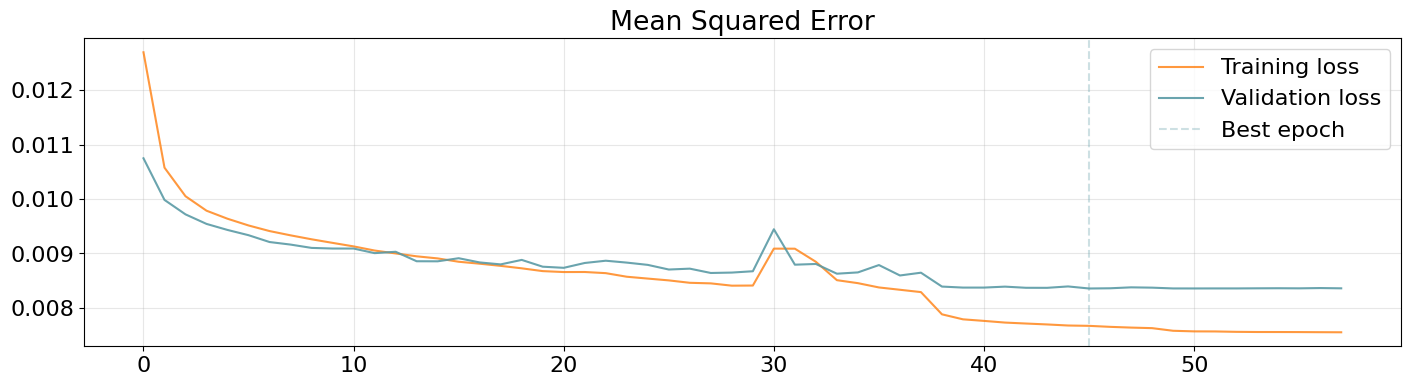

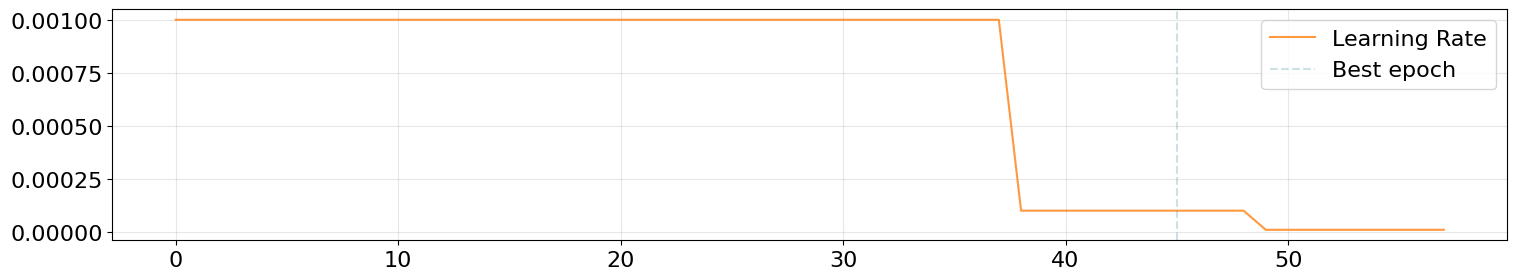

In [ ]:
plot_history(history)

In [ ]:
model.save('Forecasting_1-Bi-GRU-50')

In [ ]:
model = tfk.models.load_model('Forecasting_1-Bi-GRU-50')
mse, mae = prediction_performance(X_val,y_val,model)

ranking["Bi-GRU"] = mse, mae

Predictions shape: (92619, 9)
Mean Squared Error: 0.008151048794388771
Mean Absolute Error: 0.0552397221326828


### LSTM Encode Decode

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

print(input_shape)
print(output_shape)

(50,)
(9,)


In [ ]:
def build_lstm_enc_dec(input_shape, output_shape):

    input_layer = tfkl.Input(shape = input_shape)
    x = tfkl.Reshape((input_shape[0], 1), input_shape = input_shape)(input_layer)

    # Encoder
    x = tfkl.Bidirectional(tfkl.LSTM(100, return_sequences=True))(x)
    x = tfkl.Bidirectional(tfkl.LSTM(units=50,return_sequences=True))(x)
    x = tfkl.Bidirectional(tfkl.LSTM(units=15))(x)

    #feature vector
    x = tfk.layers.RepeatVector(output_shape[0])(x)

    #decoder
    x = tfkl.LSTM(units=100,return_sequences=True)(x)
    x = tfkl.LSTM(units=50,return_sequences=True)(x)
    output_layer = tfkl.TimeDistributed(tf.keras.layers.Dense(units=1))(x)
    output_layer = tfkl.Reshape((ouput_layer[1], -1), input_shape = output_layer)(output_layer)


    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='LSTM_ENC_DEC_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "LSTM_ENC_DEC_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 reshape (Reshape)           (None, 50, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           81600     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 50, 100)           100400    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 30)                13920     
 onal)                                                           
                                                

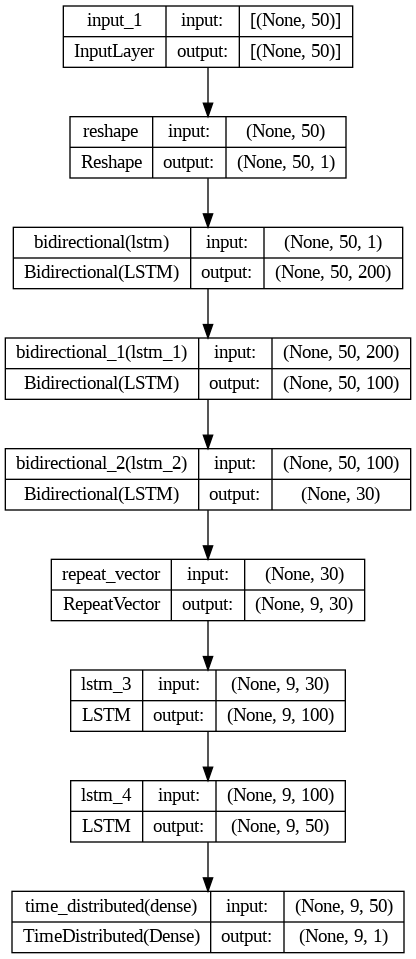

In [ ]:
model = build_lstm_enc_dec(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
5857/5857 [==============================] - 173s 27ms/step - loss: 0.0130 - val_loss: 0.0114 - lr: 0.0010
Epoch 2/200
5857/5857 [==============================] - 146s 25ms/step - loss: 0.0109 - val_loss: 0.0105 - lr: 0.0010
Epoch 3/200
5857/5857 [==============================] - 143s 24ms/step - loss: 0.0101 - val_loss: 0.0100 - lr: 0.0010
Epoch 4/200
5857/5857 [==============================] - 144s 25ms/step - loss: 0.0097 - val_loss: 0.0098 - lr: 0.0010
Epoch 5/200
5857/5857 [==============================] - 143s 24ms/step - loss: 0.0095 - val_loss: 0.0095 - lr: 0.0010
Epoch 6/200
5857/5857 [==============================] - 143s 24ms/step - loss: 0.0093 - val_loss: 0.0094 - lr: 0.0010
Epoch 7/200
5857/5857 [==============================] - 143s 24ms/step - loss: 0.0092 - val_loss: 0.0092 - lr: 0.0010
Epoch 8/200
5857/5857 [==============================] - 147s 25ms/step - loss: 0.0090 - val_loss: 0.0091 - lr: 0.0010
Epoch 9/200
5857/5857 [=========================

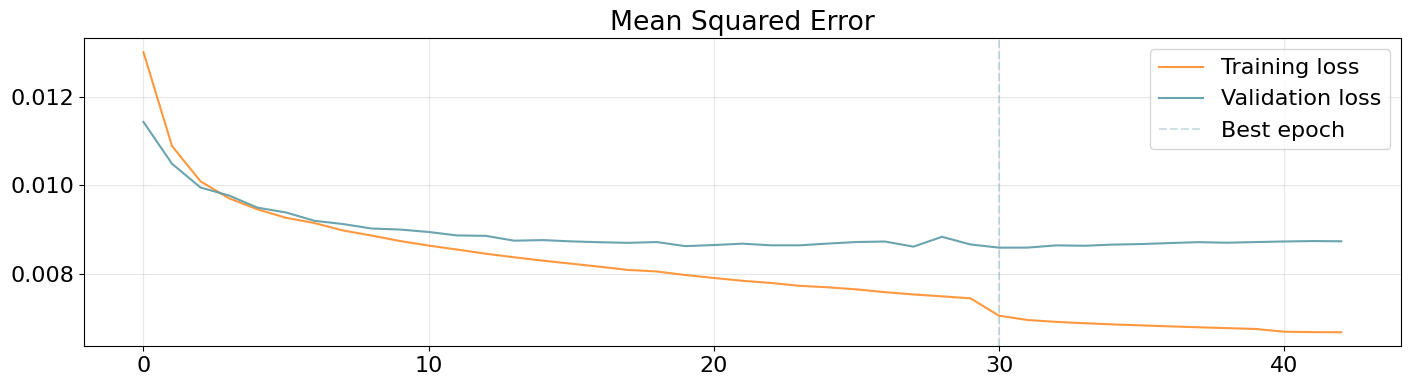

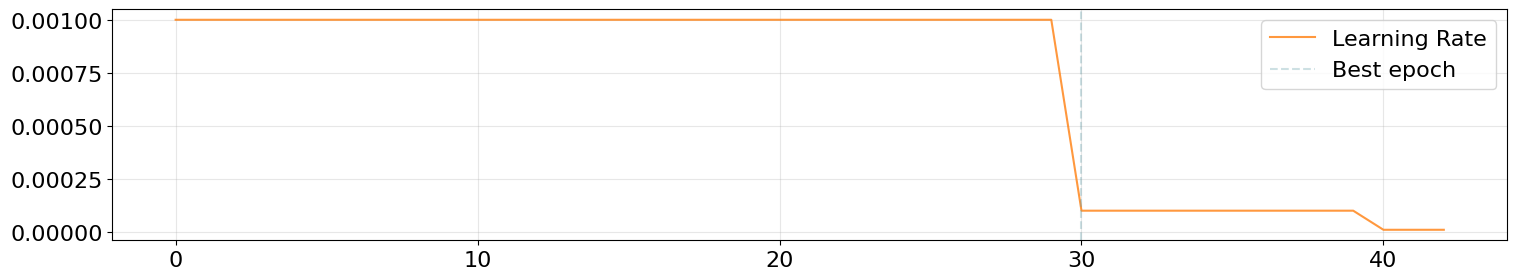

In [ ]:
plot_history(history)

In [ ]:
model.save('Forecasting_1-LSTM-ENC-DEC')

In [ ]:
model = tfk.models.load_model('Forecasting_1-LSTM-ENC-DEC')
mse, mae = prediction_performance(X_val,y_val,model)

ranking["LSTM ENC-DEC"] = mse, mae

Predictions shape: (92619, 9, 1)
Mean Squared Error: 0.008356811478734016
Mean Absolute Error: 0.05586816370487213


### ResNet adaptation for TS Forecasting


Following the ResNet structure baseline provided by [link text](https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/tree/master#network-structure) (the third one plotted in the image below)


<img src="https://raw.githubusercontent.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/master/Archi.jpg">

In [ ]:
def ResNet_block(X, n):

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # Block 1
    X = tfkl.Conv1D(filters = n, kernel_size = 7, padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)
    X = tfkl.Activation('relu')(X_shortcut)

    # Block 2
    X = tfkl.Conv1D(filters = n, kernel_size = 5, padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)
    X = tfkl.Activation('relu')(X)

    # Block 3
    X = tfkl.Conv1D(filters = n, kernel_size = 3, padding = 'same')(X)
    X = tfkl.BatchNormalization()(X)


    # Processing Residue with conv(1,1)
    X_shortcut = tfkl.Conv1D(filters = n, kernel_size = 1, padding="same")(X_shortcut)
    X_shortcut = tfkl.BatchNormalization()(X_shortcut)


    # Add Residue
    X = tfkl.add([X, X_shortcut])
    X = tfkl.Activation('relu')(X)

    return X

In [ ]:
def build_ResNet50_TS(input_shape, output_shape):

    # Define the input as a tensor with shape input_shape
    X_input = tfkl.Input(input_shape)

    # add dim for next layer
    reshape = tf.expand_dims(X_input, axis =-1)

    # Stage 1
    X = ResNet_block(reshape,n = 64)
    X = ResNet_block(X,n = 64*2)
    X = ResNet_block(X,n = 64*2)

    # AVGPOOL
    X = tfkl.GlobalAveragePooling1D(name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    output_layer = tfkl.Dense(output_shape[0], activation='linear')(X)

    # Create model
    model = tf.keras.Model(inputs=X_input, outputs=output_layer, name='ResNet_TS')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

Model: "ResNet_TS"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 tf.expand_dims (TFOpLambda  (None, 200, 1)               0         ['input_4[0][0]']             
 )                                                                                                
                                                                                                  
 activation (Activation)     (None, 200, 1)               0         ['tf.expand_dims[0][0]']      
                                                                                                  
 conv1d_1 (Conv1D)           (None, 200, 64)              384       ['activation[0][0]']  

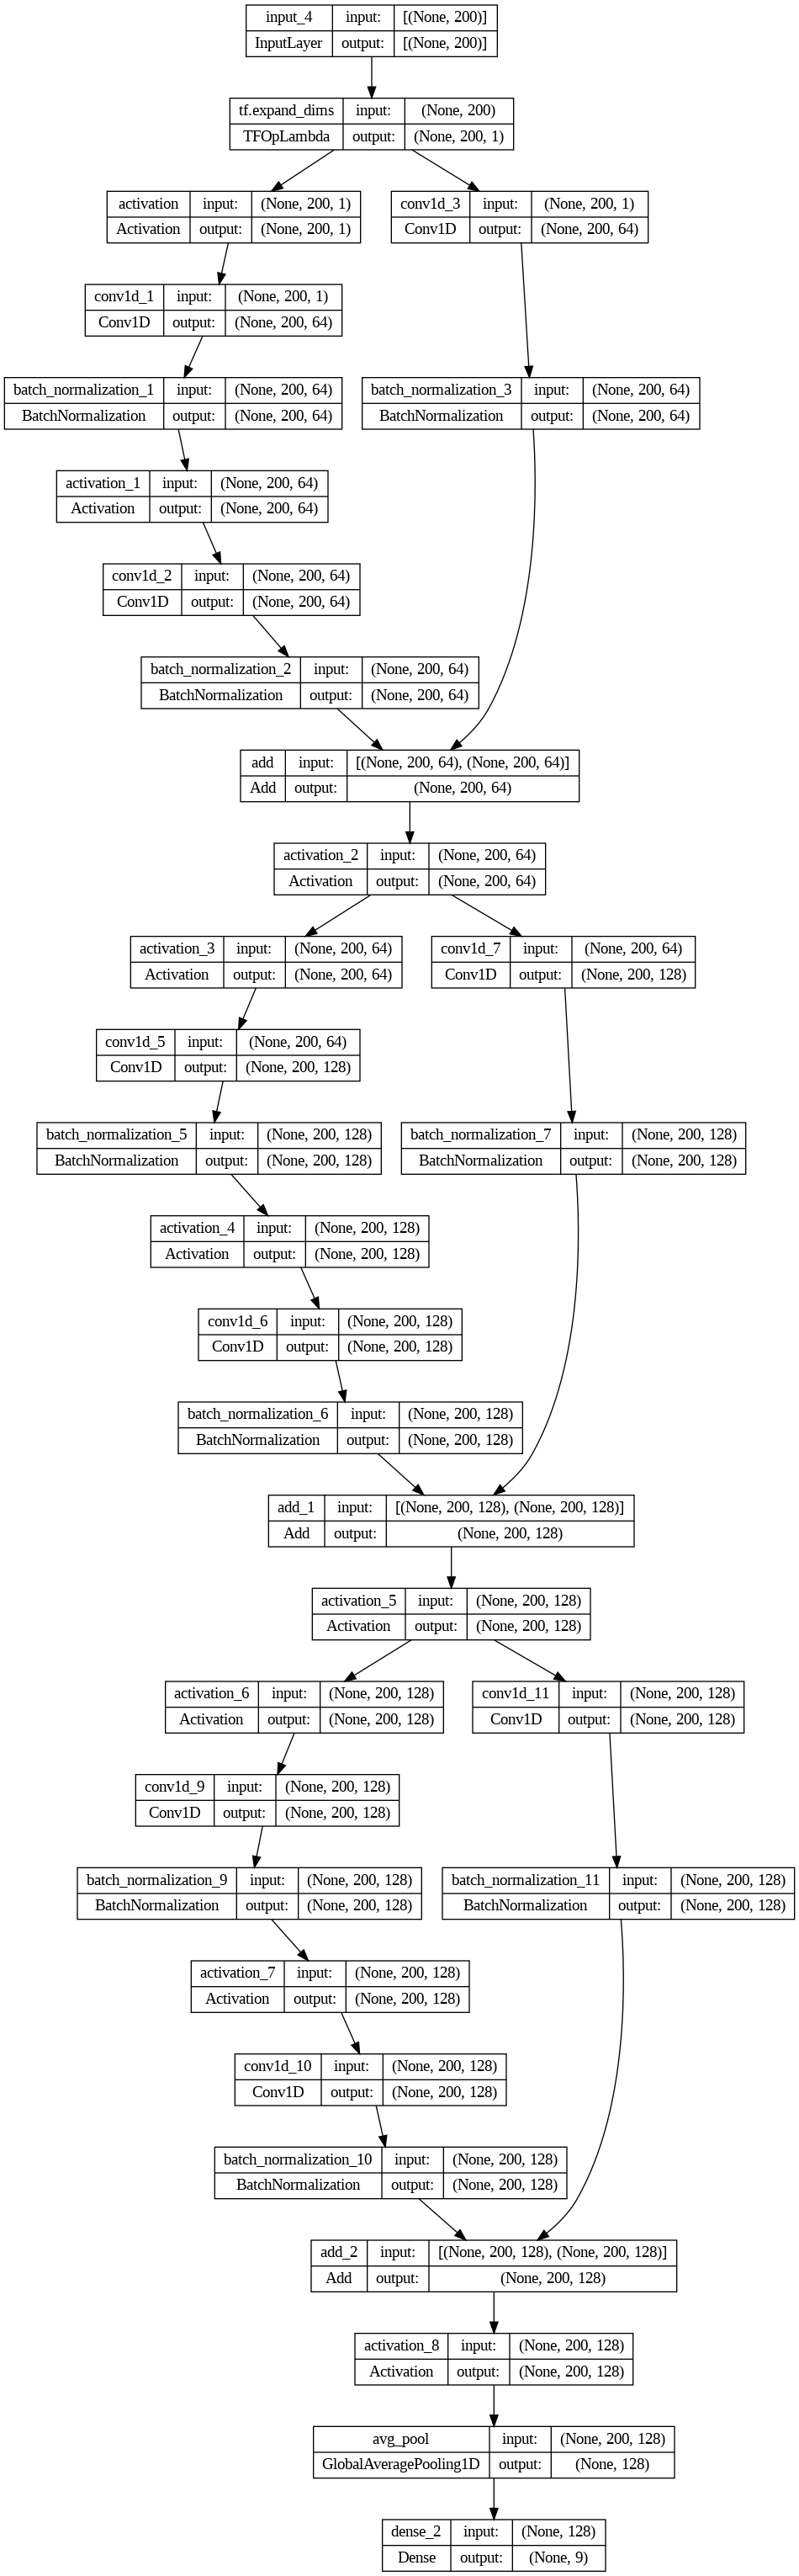

In [ ]:
model = build_ResNet50_TS(input_shape, output_shape)
#model = build_ResNet_TS(input_shape, output_shape)

model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
719/719 [==============================] - 40s 42ms/step - loss: 0.0197 - val_loss: 0.0163 - lr: 0.0010
Epoch 2/200
719/719 [==============================] - 28s 38ms/step - loss: 0.0134 - val_loss: 0.0134 - lr: 0.0010
Epoch 3/200
719/719 [==============================] - 28s 38ms/step - loss: 0.0122 - val_loss: 0.0148 - lr: 0.0010
Epoch 4/200
719/719 [==============================] - 27s 38ms/step - loss: 0.0116 - val_loss: 0.0117 - lr: 0.0010
Epoch 5/200
719/719 [==============================] - 28s 39ms/step - loss: 0.0111 - val_loss: 0.0110 - lr: 0.0010
Epoch 6/200
719/719 [==============================] - 28s 39ms/step - loss: 0.0110 - val_loss: 0.0156 - lr: 0.0010
Epoch 7/200
719/719 [==============================] - 28s 39ms/step - loss: 0.0107 - val_loss: 0.0121 - lr: 0.0010
Epoch 8/200
719/719 [==============================] - 28s 39ms/step - loss: 0.0106 - val_loss: 0.0130 - lr: 0.0010
Epoch 9/200
719/719 [==============================] - 28s 39ms/step - l

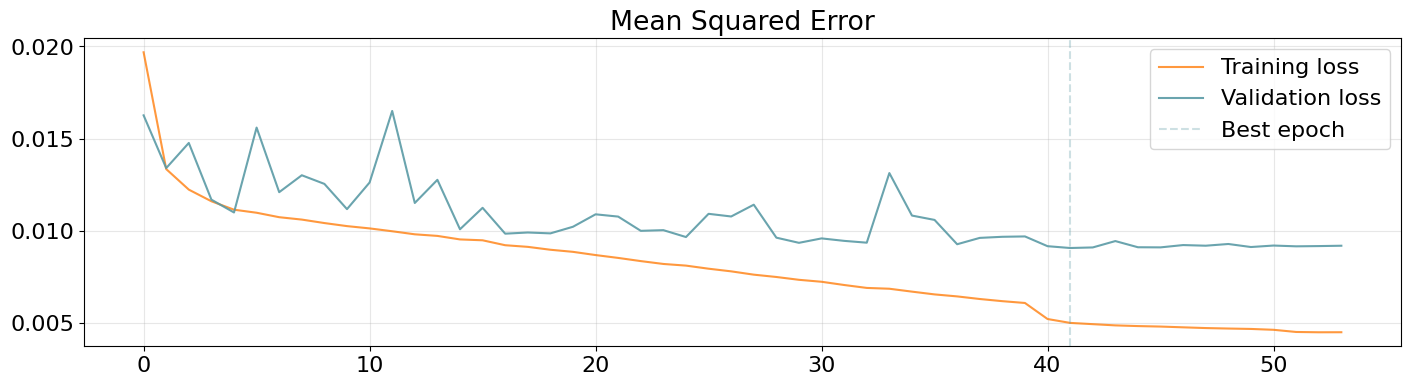

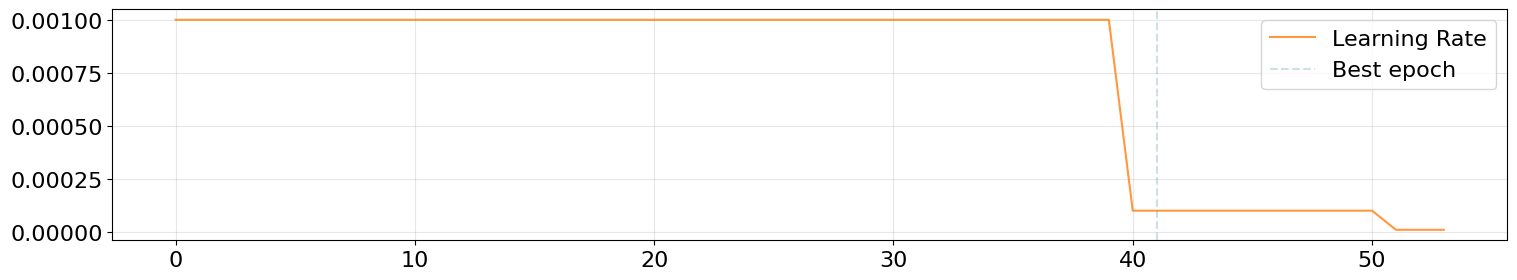

In [ ]:
plot_history(history)

In [ ]:
model.save('Forecasting_1-ResNet')

In [ ]:
model = tfk.models.load_model('Forecasting_1-ResNet')
mse, mae = prediction_performance(X_val,y_val,model)

ranking["ResNet"] = mse,mae

Predictions shape: (11322, 9)
Mean Squared Error: 0.00873962789773941
Mean Absolute Error: 0.05882764980196953


### GRU Attention model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

print(input_shape)
print(output_shape)

(50,)
(18,)


In [ ]:
def build_gru_attention(input_shape, output_shape, units):

    input_layer = tfkl.Input(shape = input_shape)
    x = tfkl.Reshape((input_shape[0], 1), input_shape = input_shape)(input_layer)
    x = tfkl.GRU (units = units, return_sequences = True)(x)
    att = tfkl.Attention()([x,x])
    x = tfkl.Concatenate(axis=-1)([x, att])
    x = tfkl.Dropout(0.2)(x)
    x = tfkl.GRU(units = units)(x)
    x = tfkl.Dropout(0.2)(x)
    output_layer = tfkl.Dense(units = output_shape[0])(x)


    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='GRU_model_attention')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
model = build_gru(input_shape, output_shape,128)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

In [ ]:
plot_history(history)

In [ ]:
model.save('Forecasting_1-GRU-Attention')

In [ ]:
model = tfk.models.load_model('Forecasting_1-GRU-Attention')
mse, mae = prediction_performance(X_val,y_val,model)

ranking["GRU Attention"] = mse, mae

### Ranking models performance

In [ ]:
res = {key: ranking[key] for key in sorted(ranking, key = lambda ele: min(ranking[ele]))}

print("------------RANKING ------------")
for key, value in res.items():
    print(f'{key}: {value}')
print("--------------------------------")

print("\n\n--------------------------------")
print(f"\tBest model is {next(iter(res))}")
print("--------------------------------")

------------RANKING ------------
GRU: (0.00828845, 0.056788005)
Bi-GRU: (0.008309799, 0.056268863)
ResNet: (0.008739628, 0.05882765)
Basic Model: (0.011557452, 0.069972046)
--------------------------------


--------------------------------
	Best model is GRU
--------------------------------
